In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from CC4_PreAmplifier import *
from signals import *

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)


plt.rcParams.update({
    'font.size': 14,          # Default text size
    'axes.titlesize': 16,     # Title size
    'axes.labelsize': 14,     # Axis label size
    'xtick.labelsize': 12,    # X-tick label size
    'ytick.labelsize': 12,    # Y-tick label size
    'legend.fontsize': 13     # Legend size
})

title_size = 16

In [3]:
MX11_data_sheet = {
    'I_DSS':30e-3, 
    'VTO':-4.2, 
    'g_m':5.6e-3, 
    'nominal_T':293.15
    }

MX11_params = infer_jfet_params(I_DSS=MX11_data_sheet['I_DSS'],
                                VTO=MX11_data_sheet['VTO'],
                                g_m=MX11_data_sheet['g_m'],
                                T=MX11_data_sheet['nominal_T'],
                                method='differential_evolution'
                                )

MX11_jfet = JFET(W_L_ratio=MX11_params['W_L_ratio'],
                a=MX11_params['a'],
                N_d=MX11_params['N_d'])

In [4]:
V_DS = np.arange(0,12,0.01)
V_GS = [1, 0,-1,-2,-3]

I_d_mx11 = np.zeros((len(V_GS),len(V_DS)))

for i,v_gs in enumerate(V_GS):
    I_d_mx11[i,:] = np.array([MX11_jfet.I_d(V_ds=v_ds,V_gs=v_gs,T=300) for v_ds in V_DS])

In [5]:
for i, v_gs in enumerate(V_GS):    
    print(v_gs,": ", np.max(I_d_mx11[i]))

1 :  0.04039023226282297
0 :  0.024064836482818205
-1 :  0.0131733538730202
-2 :  0.005948329180315086
-3 :  0.0017065021005925067


In [6]:
# Find the first maxima
sat_point_indices = [np.argmax(I_d_mx11[i, :]) for i in range(len(V_GS))]
sat_point_V_DS = [V_DS[idx] for idx in sat_point_indices][::-1]
sat_point_I_d = [I_d_mx11[i, idx] for i, idx in enumerate(sat_point_indices)][::-1]

sat_point_V_DS.insert(0,0)
sat_point_I_d.insert(0,0)

def fit_func(x, a, b, c):
    return a*x**b + c

from scipy.optimize import curve_fit

popt, pcov = curve_fit(fit_func, sat_point_V_DS, sat_point_I_d)

x_range = np.arange(0, max(sat_point_V_DS)+0.02, 0.01)
y_fit = fit_func(x_range, *popt)

/var/folders/0d/wr4vslms6rx70gkgwp1_dz400000gn/T/ipykernel_98341/1033883704.py:10: RuntimeWarning: divide by zero encountered in power
  return a*x**b + c


(-0.0020195116131411484, 0.046)

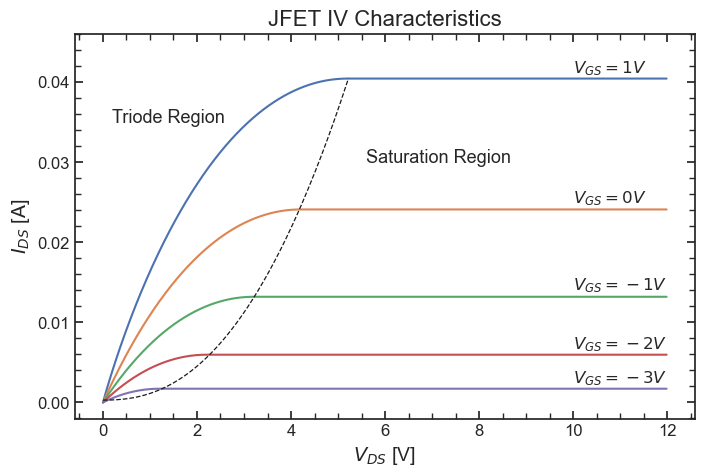

In [7]:
plt.figure(figsize=(8,5))
plt.title(f'JFET IV Characteristics', fontsize = title_size)

plt.xlabel('$V_{DS}$ [V]')
plt.ylabel('$I_{DS}$ [A]')
for i,v_gs in enumerate(V_GS):
    plt.plot(V_DS, I_d_mx11[i,:], label=f'$V_{{GS}}$ = {v_gs} V')
#plt.legend(loc=4,edgecolor="1")
plt.plot(x_range, y_fit, 'k--', lw=0.9)
plt.text(0.2, 0.035, 'Triode Region', fontsize=13)
plt.text(5.6, 0.030, 'Saturation Region', fontsize=13)
plt.text(10, 0.0412, '$V_{GS} = 1V$', fontsize=12)
plt.text(10, 0.0249, '$V_{GS} = 0V$', fontsize=12)
plt.text(10, 0.0141, '$V_{GS} = -1V$', fontsize=12)
plt.text(10, 0.0067, '$V_{GS} = -2V$', fontsize=12)
plt.text(10, 0.0025, '$V_{GS} = -3V$', fontsize=12)
plt.ylim(top=0.046)
#plt.grid(alpha=0.5)

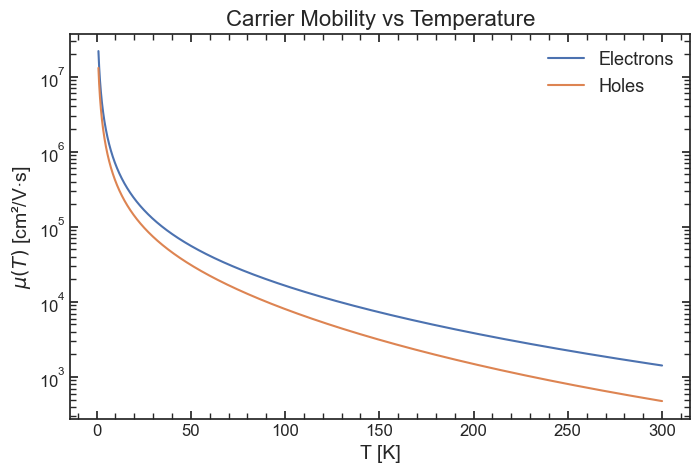

In [8]:
def mobility(T, alpha, beta, mu_0a, mu_0b, T_0=300):
    rateo = T / T_0
    A = 1/(mu_0a * rateo**(-alpha))
    B = 1/(mu_0b * rateo**(-beta))

    return 1/(A + B)

Ts = np.arange(1, 300, 0.01)  

# Electrons
alpha_e = 1.5
beta_e = 3.13
mu_0ea = 4195  # cm^2/V s
mu_0eb = 2153  # cm^2/V s

# Holes
alpha_h = 1.5
beta_h = 3.25
mu_0ha = 2502   # cm^2/V s
mu_0hb = 591    # cm^2/V s

mu_values_e = [mobility(t, alpha_e, beta_e, mu_0ea, mu_0eb) for t in Ts]
mu_values_h = [mobility(t, alpha_h, beta_h, mu_0ha, mu_0hb) for t in Ts]

plt.figure(figsize=(8, 5))
plt.plot(Ts, mu_values_e, label="Electrons")
plt.plot(Ts, mu_values_h, label="Holes")
plt.yscale("log")
plt.xlabel("T [K]")
plt.ylabel("$\mu(T)$ [cm²/V·s]")
plt.title("Carrier Mobility vs Temperature", fontsize=title_size)
plt.legend(frameon=False)
plt.show()

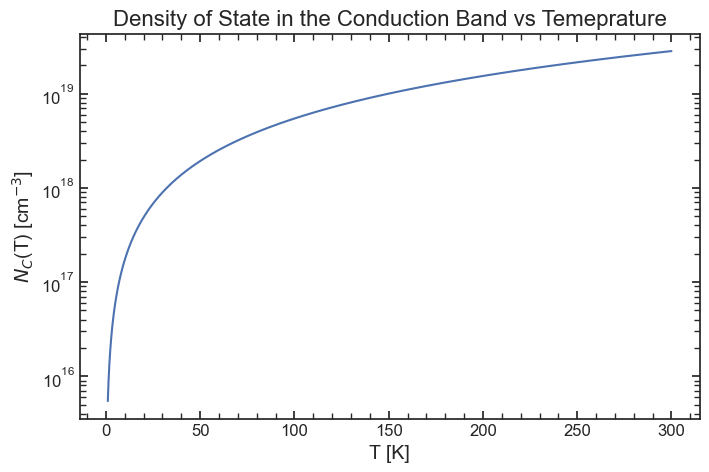

2.832032385900525e+19


In [ ]:
def density_of_state_cond_band(T):
    M_c = 6
    h = 6.62607015e-34 #mˆ2 kg/s
    k_b = 1.380649e-23 #mˆ2 kg sˆ-2 Kˆ-1
    m_0 = 9.1095e-31 #kg
    m_l = 0.98*m_0
    m_t = 0.19*m_0
    m_de = (m_l * m_t**2)**(1/3)

    num = 2*np.pi * m_de * k_b * T
    den = h**2

    return (2* M_c*(num/den)**1.5)*1e-6


Ts = np.arange(1, 300, 0.01) 

plt.figure(figsize=(8, 5))
plt.plot(Ts, density_of_state_cond_band(Ts))
plt.title("Density of State in the Conduction Band vs Temeprature", fontsize=title_size)
plt.xlabel("T [K]")
plt.ylabel("$N_C$(T) [cm$^{-3}$]")
plt.yscale("log")
plt.show()


Text(0, 0.5, '$E_g(T) [eV]$')

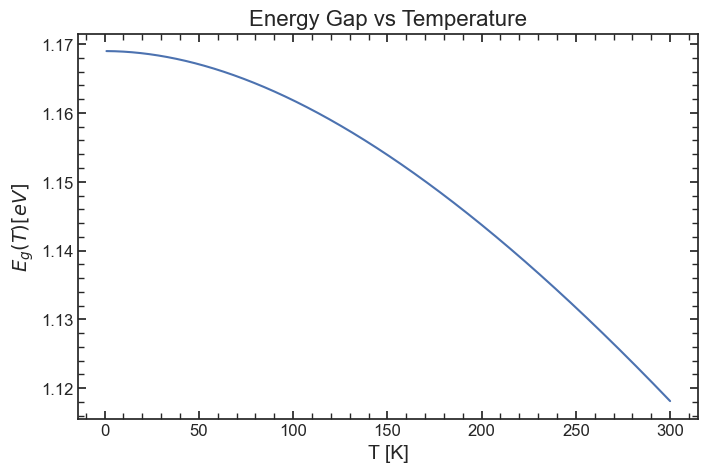

In [10]:
def energy_gap(T):
    alpha = 5.4e-4         # Parameter to adjust E_g with temperature [eV/K]
    beta = 655             # Parameter to adjust E_g with temperature [K]
    E_g_0 = 1.169
    return E_g_0 - (alpha * T**2) / (T + beta)

plt.figure(figsize=(8,5))
plt.title("Energy Gap vs Temperature", fontsize=title_size)
plt.plot(Ts, energy_gap(Ts))
plt.xlabel("T [K]")
plt.ylabel('$E_g(T) [eV]$')

